## Analysis of hydrophobicity scales

Authors: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

The cells below detail the analysis of the 98 hydrophobicity scales collected by Simm et al. [DOI: 10.1186/s40659-016-0092-5](https://doi.org/10.1186/s40659-016-0092-5).

List of SI figures:
* [Fig. S3](#S3)

In [144]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import combinations
from cycler import cycler
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 12})

In [145]:
plt.rc('axes', prop_cycle = cycler('color', ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']))
cm = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

The cell below:

* loads the parameters of the C$\alpha$-based model by Dignon et al. [DOI: 10.1371/journal.pcbi.1005941](https://doi.org/10.1371/journal.pcbi.1005941).

* loads and min-max normalizes the hydrophobicity scales collected by Simm et al. [DOI: 10.1186/s40659-016-0092-5](https://doi.org/10.1186/s40659-016-0092-5).

In [146]:
url = """https://static-content.springer.com/esm/art%3A10.1186%2Fs40659-016-0092-5/MediaObjects/
40659_2016_92_MOESM1_ESM.xlsx""".replace('\n','')

In [147]:
oneletter = ['R','D','N','E','K','H','Q','S','C','G','T','A',
             'M','Y','V','W','L','I','P','F']
ordered = ['ARG','ASP','ASN','GLU','LYS','HIS','GLN','SER','CYS','GLY','THR','ALA',
           'MET','TYR','VAL','TRP','LEU','ILE','PRO','PHE']
dfsigma = pd.read_csv('HP_scales/sigmas.txt',names=['resname','sigmas'],index_col=0,delimiter=' ')
dflambda = pd.read_csv('HP_scales/lambdas.txt',names=['resname','lambdas'],index_col=0,delimiter=' ')
allHPS = pd.read_excel(url,index_col='scale',
                       usecols=[3]+list(range(5,25))).T
map_dict = {three.capitalize(): one for three,one in zip(ordered,oneletter)}
allHPS.index = allHPS.index.map(mapper=map_dict)
allHPS = allHPS.loc[oneletter]
# min-max normalization
allHPS = (allHPS-allHPS.min())/(allHPS.max()-allHPS.min())
selHPS = allHPS.copy()
selHPS.shape[1]

98

Discard scales where the trend from R to F is decreasing (the amino acids are ordered based on the hydrophobicity scale by Kapcha and Rossky).

In [148]:
dropped = []
for h in allHPS.columns:
    popt, _ = curve_fit(lambda x,a,b : a*x+b, np.arange(0,20,1), allHPS[h])
    if popt[0]<0:
        selHPS.drop(h,axis=1,inplace=True)
        dropped.append(h)

Plot the retained 87 scales.

In [149]:
selHPS.shape[1]

87

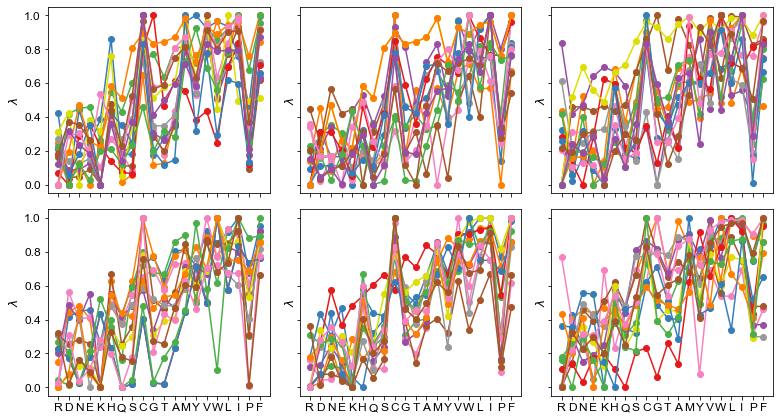

In [150]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(11,6))
for ax,h in zip(axes.flatten(),np.array_split(selHPS.columns, 6)):
    ax.plot(selHPS[h],marker='o')
    ax.set_ylabel('$\lambda$')
plt.tight_layout()
plt.show()

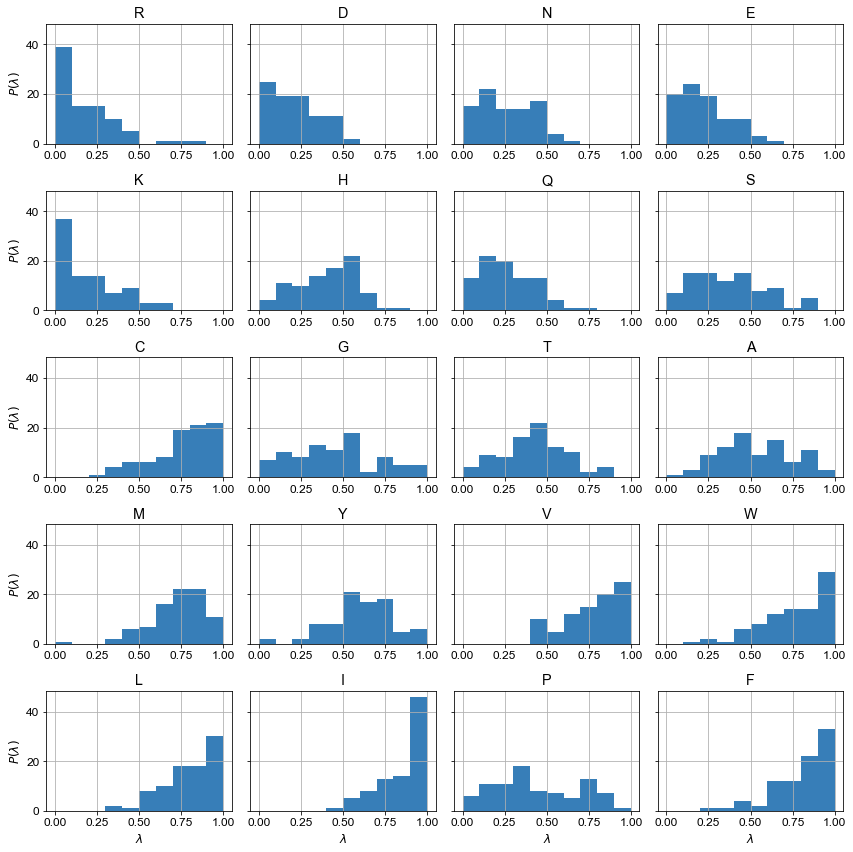

In [151]:
axes = selHPS.T.hist(bins=np.arange(0,1.1,.1), sharey=True, layout=(5, 4), figsize=(12, 12))
for ax in axes.flatten()[-4:]:
    ax.set_xlabel('$\lambda$')
for i in [0,4,8,12,16]:
    axes.flatten()[i].set_ylabel('$P(\lambda)$')
plt.tight_layout()
plt.savefig('figures/hist.pdf')
plt.show()

Calculate prior from the $\lambda$ distributions.

In [152]:
cols = np.arange(0,1.1,.1)
dfprior = pd.DataFrame(index=selHPS.index,columns=pd.cut(cols[1:],cols),
                    data=np.zeros((selHPS.index.size,np.arange(0.05,1.05,.1).size)))
for i in range(dfprior.index.size):
    h, _ = np.histogram(selHPS.iloc[i].values,bins=cols,density=True)
    dfprior.loc[selHPS.iloc[i].name] = h

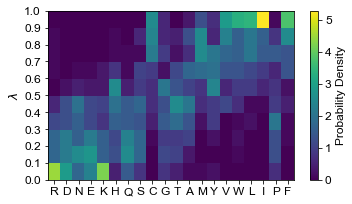

In [153]:
plt.figure(figsize=(5.2,3))
plt.rcParams.update({ 'font.size': 12 })
c = plt.pcolor(dfprior.T)
plt.xticks(np.arange(.5,20,1),labels=dfprior.index)
plt.ylabel('$\lambda$')
plt.yticks(range(11),['{:.1f}'.format(i) for i in np.arange(0,1.1,.1)])
plt.colorbar(c,label='Probability Density')
plt.tight_layout()
plt.show()

Show areas of null probability.

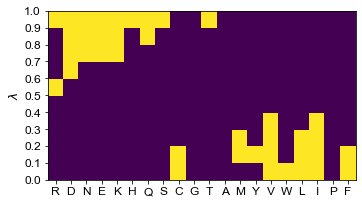

In [154]:
plt.figure(figsize=(5.2,3))
plt.rcParams.update({ 'font.size': 12 })
c = plt.pcolor(dfprior.T==0)
plt.xticks(np.arange(.5,20,1),labels=dfprior.index)
plt.ylabel('$\lambda$')
plt.yticks(range(11),['{:.1f}'.format(i) for i in np.arange(0,1.1,.1)])
plt.tight_layout()
plt.show()

Amino-acid specific parameters.

In [155]:
one = pd.Series({three: one for three,one in zip(ordered,oneletter)},name='one')
# molecular weights and molar volumes of the free amino acid from Kharakoz et al. (DOI: 10.1021/bi961781c).
mw = pd.read_csv('HP_scales/molar_volumes.dat',header=0,sep='\t',
                 index_col=0,usecols=[0,1],names=['three','MW'])
mw.index = mw.index.str.upper()
dfparams = pd.concat([one,dflambda,dfsigma/10,mw.MW],axis=1,sort=True).dropna().loc[ordered]
dfparams['q'] = [0]*dfparams.index.size # assign amino acid charges
dfparams.loc['ARG','q'] = 1
dfparams.loc['LYS','q'] = 1
dfparams.loc['GLU','q'] = -1
dfparams.loc['ASP','q'] = -1
dfparams['three'] = dfparams.index
centile10 = selHPS.quantile(.1,axis=1)
centile90 = selHPS.quantile(.9,axis=1)
average = selHPS.mean(axis=1)
median = selHPS.median(axis=1)
dfparams['centile10'] = centile10.values
dfparams['centile90'] = centile90.values
dfparams['HPS'] = dfparams.lambdas
dfparams['AVG'] = average.values
dfparams['MEDIAN'] = median.values
dfparams['lambdas'] = average.values

In [156]:
dfparams.to_csv('HP_scales/residues.csv')
dfparams

,one,lambdas,sigmas,MW,q,three,centile10,centile90,HPS,AVG,MEDIAN
ARG,R,0.158284,0.656,156.19,1,ARG,0.000000,0.363363,0.000000,0.158284,0.148148
ASP,D,0.207456,0.558,115.09,-1,ASP,0.022017,0.419964,0.378378,0.207456,0.194030
ASN,N,0.264809,0.568,114.10,0,ASN,0.047004,0.468750,0.432432,0.264809,0.246914
GLU,E,0.221740,0.592,129.11,-1,GLU,0.032260,0.430355,0.459459,0.221740,0.197917
LYS,K,0.185143,0.636,128.17,1,LYS,0.000000,0.466362,0.513514,0.185143,0.141593
HIS,H,0.409177,0.608,137.14,0,HIS,0.165191,0.607109,0.513514,0.409177,0.432000
GLN,Q,0.254641,0.602,128.13,0,GLN,0.047166,0.472174,0.513514,0.254641,0.238399
SER,S,0.372442,0.518,87.08,0,SER,0.108109,0.666086,0.594595,0.372442,0.358974
CYS,C,0.769102,0.548,103.14,0,CYS,0.445293,1.000000,0.594595,0.769102,0.797297
GLY,G,0.457316,0.450,57.05,0,GLY,0.121102,0.813575,0.648649,0.457316,0.464321


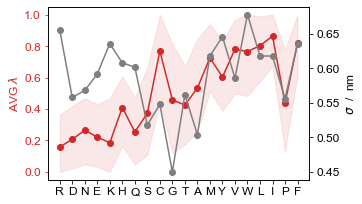

In [157]:
plt.figure(figsize=(5.2,3))
plt.rcParams.update({ 'font.size': 12 })
ax1 = plt.axes()
ax2 = ax1.twinx()
ax2.plot(dfparams.one,dfparams.sigmas.values,
         marker='o',color=plt.get_cmap('tab10')(7))
ax1.fill_between(dfparams.one,dfparams.centile10.values,
                 dfparams.centile90.values,alpha=.1,color=plt.cm.tab10(3))
ax1.plot(dfparams.one,dfparams.lambdas.values,
         marker='o',color=plt.get_cmap('tab10')(3))
ax1.set_ylabel('AVG $\lambda$',color=plt.get_cmap('tab10')(3))
ax1.tick_params(axis='y',colors=plt.get_cmap('tab10')(3))
ax2.set_ylabel('$\sigma$  /  nm',color='k')
ax2.tick_params(axis='y',colors='k')
plt.tight_layout()
plt.show()

In [158]:
dfprior.to_pickle('HP_scales/prior.pkl')

### Agglomerative Clustering

<a id='S3'></a>

### Fig. S3

In [159]:
# function from scikit-learn.org
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    print(linkage_matrix.shape)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

(91, 4)


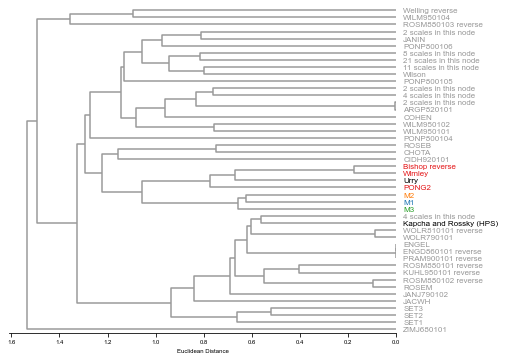

In [160]:
fig = plt.figure(figsize=(7,5))

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

plt.rc('axes', prop_cycle = cycler('color', ['#999999']*20))

dendroHPS = selHPS.copy()

dendroHPS['M1'] = pd.read_csv('residues.csv').set_index('one')['M1']
dendroHPS['M2'] = pd.read_csv('residues.csv').set_index('one')['M2']
dendroHPS['M3'] = pd.read_csv('residues.csv').set_index('one')['M3']
dendroHPS['HPS'] = pd.read_csv('residues.csv').set_index('one')['HPS']
dendroHPS['Urry'] = pd.read_csv('residues.csv').set_index('one')['Urry']+0.08

X = dendroHPS.T.values

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average', affinity='euclidean')
model = model.fit(X)

plot_dendrogram(model, truncate_mode='level', p=9, labels=dendroHPS.columns,
                leaf_rotation=0, orientation='left', distance_sort=True)

for ticklabel in plt.gca().get_yticklabels():
    ticklabel.set_color(cm[6])
    if ticklabel.get_text() in ['Bishop reverse','Wimley','PONG2']:
        ticklabel.set_color(cm[7])
    if ticklabel.get_text() in ['M1','M2','M3']:
        ticklabel.set_color(plt.cm.tab10(int(ticklabel.get_text()[1])-1))
    if ticklabel.get_text() in ['AVG', 'HPS', 'Urry']:
        ticklabel.set_color('k')
    if ticklabel.get_text() in ['HPS']:
        ticklabel.set_text('Kapcha and Rossky (HPS)') 
    if ticklabel.get_text()[0]=='(':
        ticklabel.set_text(ticklabel.get_text()[1:-1]+' scales in this node') 
        
labels = [ticklabel.get_text() for ticklabel in plt.gca().get_yticklabels()]
plt.gca().set_yticklabels(labels)
        
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.xlabel('Euclidean Distance')

plt.tight_layout()
plt.savefig('figures/dendrogram.pdf',dpi=300) 